##### Grading Feedback Cell

**Question 0 (-2 pts if not provided):**  Enter your name and SU ID in the cell below.

Your name and SU ID Here:
Yunhan Zhang & 405379315

# IST 718: Big Data Analytics

- Professors: 
  - Willard Williamson <wewillia@syr.edu>
  - Emory Creel <emcreel@g.syr.edu>
- Faculty Assistants: 
  - Warren Justin Fernandes <wjfernan@syr.edu>
  - Ruchita Hiteshkumar Harsora <	rharsora@g.syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- Google Colab is the official class runtime environment so you should test your code on Colab before submission.
- Do not modify cells marked as grading cells or marked as do not modify.
- Before submitting your work, remember to check for run time errors with the following procedure:
`Runtime `$\rightarrow$ Factory reset runtime followed by Runtime $\rightarrow$ Run All.  All runtime errors will result in a minimum penalty of half off.
- All plots shall include descriptive title and axis labels.  Plot legends shall be included where possible.  Unless stated otherwise, plots can be made using any Python plotting package.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- import * is not allowed because it is considered a very bad coding practice and in some cases can result in a significant delay (which slows down the grading process) in loading imports.  For example, the statement `from sympy import *` is not allowed.  You must import the specific packages that you need. 
- The graders reserve the right to deduct points for subjective things we see with your code.  For example, if we ask you to create a pandas data frame to display values from an investigation and you hard code the values, we will take points off for that.  This is only one of many different things we could find in reviewing your code.  In general, write your code like you are submitting it for a code peer review in industry.  
- Level of effort is part of our subjective grading.  For example, in cases where we ask for a more open ended investigation, some students put in significant effort and some students do the minimum possible to meet requirements.  In these cases, we may take points off for students who did not put in much effort as compared to students who put in a lot of effort.  We feel that the students who did a better job deserve a better grade.  We reserve the right to invoke level of effort grading at any time.
- Your notebook must run from start to finish without requiring manual input by the graders.  For example, do not mount your personal Google drive in your notebook as this will require graders to perform manual steps.  In short, your notebook should run from start to finish with no runtime errors and no need for graders to perform any manual steps.

# Medical Insurance Analysis
This assignment uses a medical insurance dataset with the following columns:
- age: age of primary beneficiary
- sex: female, male
- bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- children: Number of children covered by health insurance / Number of dependents
- smoker: Smoking
- region: the beneficiary's residential area in the US, northeast, southeast,southwest, northwest.
- charges: Individual medical costs billed by health insurance

**Note that you are required to split data into train / test / validation sets as needed to use in the pipelines created in this and future assignments**.

In [1]:
%%bash
# Do not change or modify this cell
# Need to install pyspark
# if pyspark is already installed, will print a message indicating pyspark already installed
pip install pyspark &> /dev/null

# Download the data files from github
# If the data file does not exist in the colab environment
data_file_1=insurance.csv

if [[ ! -f ./${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_1} &> /dev/null
fi

In [2]:
# load all
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml import feature
from pyspark.ml import classification
from pyspark.sql import functions as fn
from pyspark.ml import Pipeline
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, \
    MulticlassClassificationEvaluator, \
    RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import rand
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
spark = SparkSession.builder.getOrCreate()
spark_context = spark.sparkContext
sqlContext = SQLContext(spark_context)
import numpy as np
from statistics import median
from pyspark.sql.functions import when
from pyspark.sql.functions import lit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Question 1 (10 pts):
Read the data into a spark dataframe named medical_df.  Column names should be named age, sex, bmi, children, smoker, region, and charges.  Print the resulting dataframe schema and shape such that it is easy for the graders to find and interpret.  Verify your schema makes sense.  If the schema does not makes sense, fix it.

In [3]:
# Your code here
medical_df = spark.read.csv('insurance.csv', header=True, inferSchema=True) #import

medical_df_pd = medical_df.toPandas()
display(medical_df_pd.head())
display("types:", medical_df_pd.dtypes)
medical_df.printSchema()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


'types:'

age           int32
sex          object
bmi         float64
children      int32
smoker       object
region       object
charges     float64
dtype: object

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



##### Grading Feedback Cell

# Question 2 (10 pts):
Explore the data.  Make a pair plot.  Use a spark built in function to provide a statistical summary of medical_df.

Explain the following 2 items:
- What variables are positively and negatively correlated with charges.
- Provide a brief summary that highlights what is interesting about the summary statistics. 


Text(0.5, 1.01, 'Medical Data Pair Plot')

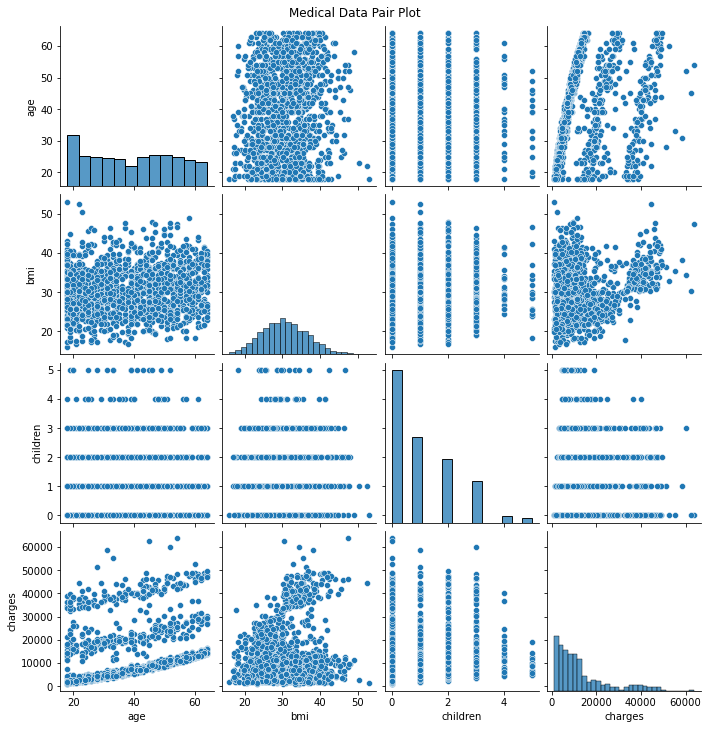

In [4]:
# Medical Data Pair Plot Using Unscaled Data
ax = sns.pairplot(medical_df.toPandas()[['age', 'bmi', 'children', 'charges']])
ax.fig.suptitle("Medical Data Pair Plot", y=1.01)

In [5]:
# statistical summary
medical_df.describe().show()

+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|summary|               age|   sex|               bmi|         children|smoker|   region|           charges|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+
|  count|              1338|  1338|              1338|             1338|  1338|     1338|              1338|
|   mean| 39.20702541106129|  null|30.663396860986538|  1.0949177877429|  null|     null|13270.422265141257|
| stddev|14.049960379216147|  null| 6.098186911679012|1.205492739781914|  null|     null|12110.011236693992|
|    min|                18|female|             15.96|                0|    no|northeast|         1121.8739|
|    max|                64|  male|             53.13|                5|   yes|southwest|       63770.42801|
+-------+------------------+------+------------------+-----------------+------+---------+------------------+



Your explanation here <br>

**What variables are positively and negatively correlated with charges?**

By looking at the pair plot, we can see that "age" and "bmi" both are positively correlated with "charges". On the other hand, "children" is negatively correlated with charges.

**Provide a brief summary that highlights what is interesting about the summary statistics.**

By looking at the summary statistics, bmi column, we may realize people overall bmi are higher than ideally bmi range; The average amount of child people have is about 1.

##### Grading Feedback Cell

# Question 3 (10 pts):
Do some data exploration.  Create 2 plots which highlight something interesting / surprising about the data. Provide descriptions of the 2 plots that you made.  Why did you make this plots and what is interesting about them. You will be graded as compared to the rest of the class on this question.

Text(0.5, 1.0, 'BMI Histogram\nUnscaled Data')

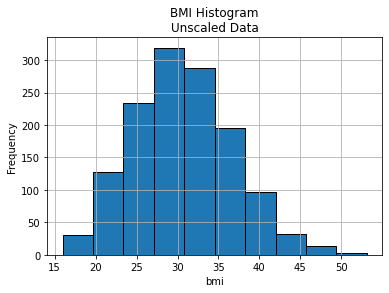

In [6]:
# Plot1
ax = medical_df.toPandas().bmi.hist(edgecolor='black')
ax.set_xlabel('bmi')
ax.set_ylabel('Frequency')
ax.set_title("BMI Histogram\nUnscaled Data")

Text(0.5, 1.0, 'charges Histogram\nUnscaled Data')

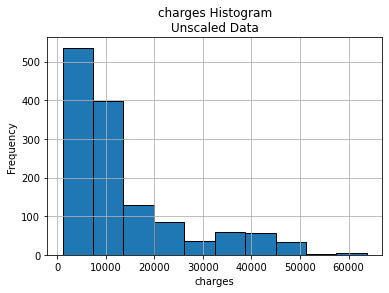

In [7]:
# Plot2
ax = medical_df.toPandas().charges.hist(edgecolor='black')
ax.set_xlabel('charges')
ax.set_ylabel('Frequency')
ax.set_title("charges Histogram\nUnscaled Data")

Your explanation here:<br> 

From the Plot1, we can see it is a bell-shape and we can tell people's overall bmi (25-35) are higher than ideally bmi range (18.5-24.9).

From the Plot2, we can see the most charges range is less than $15000.


##### Grading Feedback Cell

# Question 4 (10 pts): 
In this question you will perform feature engineering.  The medical_df is not ready for use with linear regression because some columns are categorical.  Create a new dataframe named fe_medical_df (feature engineered medical dataframe) which adds new feature engineered columns. Your feature engineering should take into account the best practices outlined in lecture.  You are free to ignore the best practices as long as your feature engineering produces better machine learning results than the best practices would have produced. We will be looking at your model scores in the following questions and grading your results as compared to the rest of the class. The feature engineering you perform in this question will have a direct result on how well your model performs below.  Encapsulate your feature engineering in a spark machine learning pipeline named fe_pipe (feature engineering pipe).

Provide an explanation on exactly what feature engineering transformations you made for every column you transform.  We expect to see a separate explanation for each and every transformation performed. 

In [8]:
# Define a sex_pipe that uses the StringIndexer to encode the gender data
sex_pipe = feature.StringIndexer(inputCol='sex', handleInvalid='skip',outputCol="sexIndex")

In [9]:
# Define a smoker_pipe that uses the StringIndexer to encode the smoker data
smoker_pipe = feature.StringIndexer(inputCol='smoker', handleInvalid='skip',outputCol="smokerIndex")

In [10]:
# Define a region_pipe that uses onehot encoder to encode the region data
region_pipe = Pipeline(stages=[feature.StringIndexer(inputCol='region', handleInvalid='skip',outputCol = "regionIndex"), 
                                 feature.OneHotEncoder(inputCol='regionIndex',outputCol = "OneHotRegion")])

In [11]:
# Applies a standard scaler function to age & charges and encapslate them with sexIndex; smokerIndex & OneHotRegion
features = Pipeline(stages=[feature.VectorAssembler(inputCols=['age', 'charges', 'sexIndex', 'smokerIndex', 
                                                                        'OneHotRegion'], 
                                                              outputCol = 'features')])

In [12]:
# collects all the pipelines together into one pipeline and read into single dataframe
fe_pipe = Pipeline(stages=[sex_pipe, smoker_pipe, region_pipe, features])
fitted_fe_pipe = fe_pipe.fit(medical_df)
fe_medical_df = fitted_fe_pipe.transform(medical_df)
pd_fe_medical_df = fe_medical_df.toPandas()
pd_fe_medical_df.head()

,age,sex,bmi,children,smoker,region,charges,sexIndex,smokerIndex,regionIndex,OneHotRegion,features
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,1.0,2.0,"(0.0, 0.0, 1.0)","[19.0, 16884.924, 1.0, 1.0, 0.0, 0.0, 1.0]"
1,18,male,33.770,1,no,southeast,1725.55230,0.0,0.0,0.0,"(1.0, 0.0, 0.0)","(18.0, 1725.5523, 0.0, 0.0, 1.0, 0.0, 0.0)"
2,28,male,33.000,3,no,southeast,4449.46200,0.0,0.0,0.0,"(1.0, 0.0, 0.0)","(28.0, 4449.462, 0.0, 0.0, 1.0, 0.0, 0.0)"
3,33,male,22.705,0,no,northwest,21984.47061,0.0,0.0,1.0,"(0.0, 1.0, 0.0)","(33.0, 21984.47061, 0.0, 0.0, 0.0, 1.0, 0.0)"
4,32,male,28.880,0,no,northwest,3866.85520,0.0,0.0,1.0,"(0.0, 1.0, 0.0)","(32.0, 3866.8552, 0.0, 0.0, 0.0, 1.0, 0.0)"


In [13]:
# Grading cell do not modify
display(fe_medical_df.show(10))
fe_medical_df.printSchema()

+---+------+------+--------+------+---------+-----------+--------+-----------+-----------+-------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sexIndex|smokerIndex|regionIndex| OneHotRegion|            features|
+---+------+------+--------+------+---------+-----------+--------+-----------+-----------+-------------+--------------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|     1.0|        1.0|        2.0|(3,[2],[1.0])|[19.0,16884.924,1...|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|     0.0|        0.0|        0.0|(3,[0],[1.0])|(7,[0,1,4],[18.0,...|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|     0.0|        0.0|        0.0|(3,[0],[1.0])|(7,[0,1,4],[28.0,...|
| 33|  male|22.705|       0|    no|northwest|21984.47061|     0.0|        0.0|        1.0|(3,[1],[1.0])|(7,[0,1,5],[33.0,...|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|     0.0|        0.0|        1.0|(3,[1],[1.0])|(7,[0,1,5],[32

None

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)
 |-- sexIndex: double (nullable = false)
 |-- smokerIndex: double (nullable = false)
 |-- regionIndex: double (nullable = false)
 |-- OneHotRegion: vector (nullable = true)
 |-- features: vector (nullable = true)



Your explanation here:<br>

Define a sex_pipe that uses the StringIndexer to encode the gender data & Define a smoker_pipe that uses the StringIndexer to encode the smoker data because these two variables only have 2 categories, can simply encode as 0/1.

Define a region_pipe that uses onehot encoder to encode the region data because 'region does not maintain relationships between categories so is best used on plain categorical data.

##### Grading Feedback Cell

# Question 5 (10 pts):

Create a new pipeline named lr_pipe which encapsulates fe_pipe, any needed linear regression support objects, and a linear regression object. Linear regression support objects are anything you need over and above what is in fe_pipe in order to successfully run linear regression. Write some code that prints out the stage names of lr_pipe and fe_pipe such that it's easy for the graders to find and interpret. We don't expect to have to read code to interpret your results.

Train and test lr_pipe using medical_df. To evaluate lr_pipe, first write a spark expression to compute MSE on the resulting fitted model. Second, use a built in spark evaluator object to compute MSE. Print out the results from both your expression and the built in evaluator object such that it's easy for the graders to find, interpret, and distinguish between the 2 test cases. We don't expect to have to reverse engineer your code to interpret the results.

In [14]:
# your code here
lr = regression.LinearRegression(featuresCol='features', labelCol='bmi')

In [15]:
lr_pipe = Pipeline(stages=[fe_pipe, lr])

In [16]:
lr_pipe.getStages()
# lr_pipe.stages

[Pipeline_ab2993b23abe, LinearRegression_1e6104b1b4ba]

In [17]:
fe_pipe.getStages()

[StringIndexer_f997303ca2f1,
 StringIndexer_8ff99da507cd,
 Pipeline_092012a4df1d,
 Pipeline_3b932a4be0c7]

In [18]:
# Train
training, test = medical_df.randomSplit([0.8, 0.2], 0)
training.show(5)
test.show(5)

+---+------+------+--------+------+---------+----------+
|age|   sex|   bmi|children|smoker|   region|   charges|
+---+------+------+--------+------+---------+----------+
| 18|female| 20.79|       0|    no|southeast| 1607.5101|
| 18|female| 21.66|       0|   yes|northeast|14283.4594|
| 18|female| 24.09|       1|    no|southeast| 2201.0971|
| 18|female| 25.08|       0|    no|northeast| 2196.4732|
| 18|female|26.315|       0|    no|northeast|2198.18985|
+---+------+------+--------+------+---------+----------+
only showing top 5 rows

+---+------+------+--------+------+---------+----------+
|age|   sex|   bmi|children|smoker|   region|   charges|
+---+------+------+--------+------+---------+----------+
| 18|female| 36.85|       0|    no|southeast| 1629.8335|
| 18|female| 36.85|       0|   yes|southeast|36149.4835|
| 18|female| 39.82|       0|    no|southeast| 1633.9618|
| 18|female|40.185|       0|    no|northeast|2217.46915|
| 18|female| 40.26|       0|    no|southeast| 1634.5734|
+---+-

In [19]:
trained_medical_model = lr_pipe.fit(training)
lr_predictions = trained_medical_model.transform(test)
lr_predictions.toPandas().head()

,age,sex,bmi,children,smoker,region,charges,sexIndex,smokerIndex,regionIndex,OneHotRegion,features,prediction
0,18,female,36.850,0,no,southeast,1629.83350,0.0,0.0,0.0,"(1.0, 0.0, 0.0)","(18.0, 1629.8335, 0.0, 0.0, 1.0, 0.0, 0.0)",31.429146
1,18,female,36.850,0,yes,southeast,36149.48350,0.0,1.0,0.0,"(1.0, 0.0, 0.0)","[18.0, 36149.4835, 0.0, 1.0, 1.0, 0.0, 0.0]",33.950689
2,18,female,39.820,0,no,southeast,1633.96180,0.0,0.0,0.0,"(1.0, 0.0, 0.0)","(18.0, 1633.9618, 0.0, 0.0, 1.0, 0.0, 0.0)",31.430146
3,18,female,40.185,0,no,northeast,2217.46915,0.0,0.0,3.0,"(0.0, 0.0, 0.0)","(18.0, 2217.46915, 0.0, 0.0, 0.0, 0.0, 0.0)",27.584765
4,18,female,40.260,0,no,southeast,1634.57340,0.0,0.0,0.0,"(1.0, 0.0, 0.0)","(18.0, 1634.5734, 0.0, 0.0, 1.0, 0.0, 0.0)",31.430294


In [20]:
trained_medical_model.stages

[PipelineModel_8330c0da6ffb,
 LinearRegressionModel: uid=LinearRegression_1e6104b1b4ba, numFeatures=7]

In [21]:
# MSE1
mse = fn.mean((fn.col('bmi') - fn.col('prediction'))**2).alias('mse')
lr_predictions.select(mse).show()

+------------------+
|               mse|
+------------------+
|32.712207183982834|
+------------------+



In [22]:
# MSE2
valuesAndPreds = lr_predictions.select(['bmi', 'prediction'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)
metrics = RegressionMetrics(valuesAndPreds)
# Squared Error
print("MSE = %s" % metrics.meanSquaredError)

MSE = 32.712207183982834


##### Grading Feedback Cell

# Question 6 (10 pts):
The goal of this question is to build a pipeline which can be used to perform inference.  Create a new pipeline named inf_pipe which encapsulates fe_pipe and adds new spark ML statistical components, linear regression support components, and a linear regression object.  The goal is to compare linear regression coefficients between each other in order to learn something about the data set.  Exclude any features which are not useful to the analysis.  inf_pipe Shall use the charges column as the target.  Score inf_pipe using a spark built in evaluator with the MSE scoring metric.  The output dataframe shall be named inf_medical_df.

Explanation:  First, explain what spark ML statistical component(s) you added to inf_pipe which were needed in order to be able to compare linear regression components between each other.  Second, explain what features you excluded from the analysis (if any) and why.

In [23]:
# Applies a standard scaler function to age & bmi and encapslate them with sexIndex; smokerIndex & OneHotRegion
q6_features = Pipeline(stages=[feature.VectorAssembler(inputCols=['age', 'bmi'], 
                                                              outputCol = 'num_features'),
                                      feature.StandardScaler(inputCol="num_features", outputCol="scaledFeatures"),
                                      feature.VectorAssembler(inputCols=['scaledFeatures', 'sexIndex', 'smokerIndex', 
                                                                     'children'], 
                                                              outputCol = 'q6_features')])

In [24]:
# Creating inf_pipe
fe_pipe_q6 = Pipeline(stages=[sex_pipe, smoker_pipe, q6_features])

In [25]:
fitted_fe_pipe_q6 = fe_pipe_q6.fit(medical_df)
inf_medical_df = fitted_fe_pipe_q6.transform(medical_df)
inf_medical_df_pd = inf_medical_df.toPandas()
inf_medical_df_pd.head()

,age,sex,bmi,children,smoker,region,charges,sexIndex,smokerIndex,num_features,scaledFeatures,q6_features
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,1.0,"[19.0, 27.9]","[1.352316980772868, 4.575130346786681]","[1.352316980772868, 4.575130346786681, 1.0, 1...."
1,18,male,33.770,1,no,southeast,1725.55230,0.0,0.0,"[18.0, 33.77]","[1.281142402837454, 5.537711534443951]","[1.281142402837454, 5.537711534443951, 0.0, 0...."
2,28,male,33.000,3,no,southeast,4449.46200,0.0,0.0,"[28.0, 33.0]","[1.9928881821915951, 5.411444496199301]","[1.9928881821915951, 5.411444496199301, 0.0, 0..."
3,33,male,22.705,0,no,northwest,21984.47061,0.0,0.0,"[33.0, 22.705]","[2.348761071868666, 3.7232377965516696]","(2.348761071868666, 3.7232377965516696, 0.0, 0..."
4,32,male,28.880,0,no,northwest,3866.85520,0.0,0.0,"[32.0, 28.88]","[2.2775864939332515, 4.735833850007145]","(2.2775864939332515, 4.735833850007145, 0.0, 0..."


In [26]:
q6_lr = regression.LinearRegression(featuresCol='q6_features', labelCol='charges')
inf_pipe = Pipeline(stages=[fe_pipe_q6, q6_lr])

In [27]:
# Train & Test
trained_inf_model = inf_pipe.fit(training)
inf_predictions = trained_inf_model.transform(test)
inf_predictions.toPandas().head()

,age,sex,bmi,children,smoker,region,charges,sexIndex,smokerIndex,num_features,scaledFeatures,q6_features,prediction
0,18,female,36.850,0,no,southeast,1629.83350,0.0,0.0,"[18.0, 36.85]","[1.2719389142106288, 6.1218434925164305]","(1.2719389142106288, 6.1218434925164305, 0.0, ...",3942.752887
1,18,female,36.850,0,yes,southeast,36149.48350,0.0,1.0,"[18.0, 36.85]","[1.2719389142106288, 6.1218434925164305]","[1.2719389142106288, 6.1218434925164305, 0.0, ...",28331.722865
2,18,female,39.820,0,no,southeast,1633.96180,0.0,0.0,"[18.0, 39.82]","[1.2719389142106288, 6.6152458038535755]","(1.2719389142106288, 6.6152458038535755, 0.0, ...",4757.178858
3,18,female,40.185,0,no,northeast,2217.46915,0.0,0.0,"[18.0, 40.185]","[1.2719389142106288, 6.675882788243494]","(1.2719389142106288, 6.675882788243494, 0.0, 0...",4857.268244
4,18,female,40.260,0,no,southeast,1634.57340,0.0,0.0,"[18.0, 40.26]","[1.2719389142106288, 6.688342442570189]","(1.2719389142106288, 6.688342442570189, 0.0, 0...",4877.834557


In [28]:
# MSE
valuesAndPreds2 = inf_predictions.select(['charges', 'prediction'])
valuesAndPreds2 = valuesAndPreds2.rdd.map(tuple)
metrics2 = RegressionMetrics(valuesAndPreds2)
# Squared Error
print("MSE = %s" % metrics2.meanSquaredError)

MSE = 43620997.90325987


In [29]:
print(trained_inf_model.stages[-1].coefficients)

[3649.054229520611,1650.6326618857358,36.0213912796889,24388.96997779223,482.13751364019623]


In [30]:
# Grading cell do not modify
display(inf_medical_df.show(10))

+---+------+------+--------+------+---------+-----------+--------+-----------+-------------+--------------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sexIndex|smokerIndex| num_features|      scaledFeatures|         q6_features|
+---+------+------+--------+------+---------+-----------+--------+-----------+-------------+--------------------+--------------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|     1.0|        1.0|  [19.0,27.9]|[1.35231698077286...|[1.35231698077286...|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|     0.0|        0.0| [18.0,33.77]|[1.28114240283745...|[1.28114240283745...|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|     0.0|        0.0|  [28.0,33.0]|[1.99288818219159...|[1.99288818219159...|
| 33|  male|22.705|       0|    no|northwest|21984.47061|     0.0|        0.0|[33.0,22.705]|[2.34876107186866...|(5,[0,1],[2.34876...|
| 32|  male| 28.88|       0|    no|northwest|  3866.855

None

##### Grading Feedback Cell

Your explanation here:<br>

I applied the standard scaler function to age & charges because they all have different units and Linear regression does not require standardization for training but it does allow you to compare the resulting coefficients to each other. Besides that, I excluded 'region' from the analysis because it has no coefficient with 'charges' in other words, it does not make sense when we try to predict charges in this analysis.

##### Grading Feedback Cell

# Question 7 (10 pts):
Extract the linear regression coefficients from inf_pipe and collect them in a pandas dataframe named inf_pd.  The inf_pd dataframe shall have 2 columns: predictor and value.  Load the predictor column with the name of the coefficient and the value column with the linear coefficient values from the linear regression model.  Sort inf_pd by the value column in ascending order. 

In [31]:
# your code here
value = np.array(trained_inf_model.stages[-1].coefficients)
predictor = np.array(['age', 'bmi','sex', 'smoker','children'])
inf_pd = pd.DataFrame({'predictor':predictor, 'value':value})

In [32]:
inf_pd = inf_pd.sort_values(by='value', ascending=True)

In [33]:
# Grading cell do not modify
display(inf_pd)

,predictor,value
2,sex,36.021391
4,children,482.137514
1,bmi,1650.632662
0,age,3649.054230
3,smoker,24388.969978


##### Grading Feedback Cell

# Question 8 (10 pts):
Create a new dataframe named strat_med_df (stratified medical dataframe) by adding a new column to fe_medical_df named rate_pool.  Create the rate_pool column by stratifying the charges column into charges greater than and less than the median of the charges column.  Assign an integer 0 to charges that are less than or equal to the median, and a 1 to charges greater than the median.  What is the most important positive and negative predictors?

In [34]:
# your code here
chagres_median = median(inf_medical_df_pd['charges'])

In [35]:
strat_med_df = inf_medical_df.withColumn("rate_pool", \
   when((inf_medical_df.charges <= chagres_median), lit(0)) \
     .when((inf_medical_df.charges > chagres_median), lit(1)) \
  )

In [36]:
# grading cell do not modify
display(strat_med_df.show(10))
strat_med_df.printSchema()

+---+------+------+--------+------+---------+-----------+--------+-----------+-------------+--------------------+--------------------+---------+
|age|   sex|   bmi|children|smoker|   region|    charges|sexIndex|smokerIndex| num_features|      scaledFeatures|         q6_features|rate_pool|
+---+------+------+--------+------+---------+-----------+--------+-----------+-------------+--------------------+--------------------+---------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|     1.0|        1.0|  [19.0,27.9]|[1.35231698077286...|[1.35231698077286...|        1|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|     0.0|        0.0| [18.0,33.77]|[1.28114240283745...|[1.28114240283745...|        0|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|     0.0|        0.0|  [28.0,33.0]|[1.99288818219159...|[1.99288818219159...|        0|
| 33|  male|22.705|       0|    no|northwest|21984.47061|     0.0|        0.0|[33.0,22.705]|[2.34876107186866...|(5,[0,1],[2.34876

None

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)
 |-- sexIndex: double (nullable = false)
 |-- smokerIndex: double (nullable = false)
 |-- num_features: vector (nullable = true)
 |-- scaledFeatures: vector (nullable = true)
 |-- q6_features: vector (nullable = true)
 |-- rate_pool: integer (nullable = true)



##### Grading Feedback Cell

Your most important positive / negative predictor here:<br>

The most positive predictor is 'smoker'; on the other hand, the most negative predictor is 'sex'.

##### Grading Feedback Cell

# Question 9 (10 pts):
Create a new pipeline named strat_pipe which predicts the rate_pool column in strat_med_df.  Train and test strat_pipe using strat_med_df.  Score strat_pipe using a built in spark evaluator, 3 fold cross validation, and an AUC (area under the ROC curve) scoring metric. 

In [37]:
# Train
train, test = strat_med_df.randomSplit([0.8, 0.2], )
train.show(5)
test.show(5)

+---+------+------+--------+------+---------+----------+--------+-----------+-------------+--------------------+--------------------+---------+
|age|   sex|   bmi|children|smoker|   region|   charges|sexIndex|smokerIndex| num_features|      scaledFeatures|         q6_features|rate_pool|
+---+------+------+--------+------+---------+----------+--------+-----------+-------------+--------------------+--------------------+---------+
| 18|female| 20.79|       0|    no|southeast| 1607.5101|     1.0|        0.0| [18.0,20.79]|[1.28114240283745...|[1.28114240283745...|        0|
| 18|female| 21.66|       0|   yes|northeast|14283.4594|     1.0|        1.0| [18.0,21.66]|[1.28114240283745...|[1.28114240283745...|        1|
| 18|female| 24.09|       1|    no|southeast| 2201.0971|     1.0|        0.0| [18.0,24.09]|[1.28114240283745...|[1.28114240283745...|        0|
| 18|female| 25.08|       0|    no|northeast| 2196.4732|     1.0|        0.0| [18.0,25.08]|[1.28114240283745...|[1.28114240283745...|   

In [38]:
q9_lr = classification.LogisticRegression(featuresCol='q6_features', labelCol='rate_pool')
strat_pipe = Pipeline(stages=[q9_lr])

In [39]:
paramGrid = ParamGridBuilder() \
    .addGrid(q9_lr.elasticNetParam, [0., 0.01, 0.1]) \
    .addGrid(q9_lr.regParam, [0.1, 0.01, 0.001, 0.0001]) \
    .build()

In [40]:
# evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="rate_pool")
evaluator = BinaryClassificationEvaluator(labelCol=q9_lr.getLabelCol(), rawPredictionCol=q9_lr.getRawPredictionCol())
crossval = CrossValidator(estimator = strat_pipe, 
                          estimatorParamMaps = paramGrid, 
                          evaluator = evaluator, 
                          numFolds=3)

In [41]:
final_model_fitted = crossval.fit(train)

In [42]:
final_model_fitted.avgMetrics

[0.9422931292874626,
 0.9437817509167474,
 0.9448285784056127,
 0.9449701056124067,
 0.942478032494432,
 0.943893232087974,
 0.9449285916998311,
 0.9448440886994792,
 0.9423179307475862,
 0.9437896995198802,
 0.944859985905745,
 0.9449975844063163]

In [43]:
final_model_tested = final_model_fitted.transform(test)
evaluator.evaluate(final_model_tested)

0.9561911446452601

In [44]:
trainingCoe = final_model_fitted.bestModel.stages[-1].coefficients
trainingCoe

DenseVector([2.2843, 0.051, 0.253, 10.3525, 0.1336])

##### Grading Feedback Cell

# Question 10 (10 pts):
Create an ROC plot from the results of question 9 above.  Explain the process of how a ROC curve is created (don't tell me how your code works, tell me how a ROC curve is created).  Describe the main points of how a ROC curve is created and convince me that you understand the high level process of how to create a ROC curve.

In [46]:
final_model_fitted.bestModel.stages[-1]

LogisticRegressionModel: uid=LogisticRegression_00b5cf67739b, numClasses=2, numFeatures=5

In [143]:
# final_model_fitted.bestModel.stages[-1].summary.roc.select('FPR').collect()
# final_model_fitted.bestModel.stages[-1].summary.roc.select('TPR').collect()

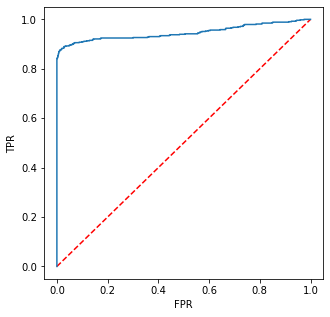

In [47]:
# ROC Plot
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(final_model_fitted.bestModel.stages[-1].summary.roc.select('FPR').collect(),
         final_model_fitted.bestModel.stages[-1].summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

##### Grading Feedback Cell

Your explanation here:<br>

An ROC curve is able to show the performance of a classification model at all classification thresholds. This curve plots two parameters: True Positive Rate. False Positive Rate. For example, in logistic regression, the threshold would be the predicted probability of an observation belonging to the positive class.

The step to create a ROC curve:
1. Fit the logistic Regression Model.
2. Calculate the true positive rate and the false positive rate and create a ROC curve.
3. Calculate the AUC

The Area Under the Curve (AUC) represents the performance.AUC ROC can be interpreted as the probability that the scores given by a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one.The AUC for the red diagonal line represents the “random guess” performance.

##### Grading Feedback Cell

**Extra Credit (5 pts)**  This question is optional.  If you choose to answer this question, you will earn 5 extra credit points.  If you choose not to answer this question, no points will be deducted from your score.  Solve the following equation for $c$ symbolically using the python sympy package.  Convert the solved symbolic solution to a latex format (this can be done with a python call), then populate the solution cell with the resulting latex code so that your solution shows up symbolically - similar the way that the equation below is rendered.

$$c g - c h + e \left(a + 1\right)^{b} - \frac{d \left(\left(a + 1\right)^{b} - 1\right)}{a} + \frac{f \left(\left(a + 1\right)^{b} - 1\right)}{a} = 0$$

In [ ]:
# your code here

Your solved equation in latex here such that it renders as a human readable equation:<br>
